# Session 5 (Bonus): Implementing a simple Eco-Evolutionary simulation

In all precedent sessions, we saw how to control simulation from notebook by modifying agents behaviors, manipulating their sensors, their diets ... how to make resources spawn, assign species to agents ......, attach routines ...

Now we are going to see how we can combine all these features to implement a simple Eco-Evolutionary simulation ! 

An eco-evolutionary simulation is a virtual environment where small agents (like robots) interact with each other and their surroundings. Over time, these agents adapt and evolve based on environmental challenges and competition for resources. The simulation models both ecological processes (like food gathering or predator-prey relationships) and evolutionary changes (like traits being passed down to future generations).

In [27]:
controller.stop()

In [1]:
import numpy as np

from vivarium.controllers.notebook_controller import NotebookController
#from vivarium.utils.handle_server_interface import start_server_and_interface, stop_server_and_interface

Start running the controller and check the subtypes of this session

In [2]:
controller = NotebookController()

In [3]:
controller.run()

In [4]:
controller.agents[0].left_motor = 0.5
controller.print_subtypes_list()

['robots', 'resources']


In [5]:
controller.agents[0].left_motor = 0.

define behaviors in advance like in the precedent notebook

In [6]:
def behavior(sensed, params):
    def fn(agent):
        s = agent.sensors(sensed_entities=[sensed])
        s = np.array(s + [1.]).reshape(-1, 1)
        m = np.dot(params, s).reshape(-1)
        m = np.clip(m, 0, 1)
        return m[0], m[1]
    return fn
    
# Test the behavior function
params = np.array([[0, 1., 0.], [1., 0., 0]])
test_agent = controller.agents[2]
 #test_agent.sensors = lambda sensed_entities: [0.5, 0.2]


# Define a test function
def test_behavior():
    print(test_agent.sensors(sensed_entities=["robots"]))
    m = behavior("robots", params)(test_agent)
    print(f"Output of behavior function: {m}")

test_behavior()

[0.0, 0]
Output of behavior function: (0.0, 0.0)


In [7]:
def attach_param_behaviors(agent):
    for entity, params in agent.behavior_params.items():
        agent.attach_behavior(behavior(entity, params), interval=1)

In [8]:
def energy(agent):
    if agent.has_eaten():
        agent.energy += 2.1
        # print('has_eaten', agent.energy)
    else:
        agent.energy -= 0.005
        # print('lose energy', agent.energy)

def death(agent):
    if agent.energy <= 0:
        agent.exists = False

In [9]:
init_energy = 1.

In [10]:
def init_agent(agent, position=None, params=None):
    agent.energy = init_energy
    if position is not None:
        agent.x_position = position[0]
        agent.y_position = position[1]
    else:
        agent.x_position = np.random.uniform(0, controller.box_size)
        agent.y_position = np.random.uniform(0, controller.box_size)
    agent.detach_all_behaviors(stop_motors=True)
    agent.detach_all_routines()
    agent.diet = ["resources"]
    agent.ate = False
    agent.exists = True
    if params is not None:
        agent.behavior_params = params
    else:
        agent.behavior_params = {}
        for entity in controller.subtypes_labels.values():
            agent.behavior_params[entity] = 2 * np.random.rand(2, 3) - 1
    attach_param_behaviors(agent)

def start_agent(agent):
    agent.start_all_behaviors()
    agent.attach_routine(energy, interval=1)
    agent.attach_routine(death, interval=1)    

In [11]:
for agent in controller.agents:
    init_agent(agent)

In [12]:
# spawn the a new agent every time an agent has eaten !
max_distance = 20.

def asexual_reproduction(controller):
    # iterate over all agents in the controller
    for robot in controller.agents: 
        # check if the robot has eaten and if it is alive
        if robot.exists and robot.energy > 2 * init_energy:
            print('REPRODUCTION STARTED')
            robot.energy -= init_energy
            # get the index of the dead agents to select one and make it spawn
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            # check if there are dead agents (if dead_agents_idx an empty list, do nothing)
            if dead_agents_idx:
                # if there are dead agents, select one randomly
                agent_idx = np.random.choice(dead_agents_idx)
                # add some noise to the position of the parent
                epsilon = np.random.uniform(-max_distance, max_distance, 2)
                position = [robot.x_position, robot.y_position]
                new_position = position + epsilon

                # give the new position to the spawn entity
                offspring = controller.agents[agent_idx]  #controller.spawn_entity(agent_idx, position=new_position) 
                offspring.diameter = robot.diameter + 0.1
                behavior_params = {entity: np.random.normal(params, 0.1) for entity, params in robot.behavior_params.items()}
                init_agent(offspring, position=new_position, params=behavior_params)   
                start_agent(offspring)
                #attach_param_behaviors(offspring)
                #offspring.energy = init_energy
                #offspring.attach_routine(energy, interval=1)
                #offspring.attach_routine(death, interval=1)
                #offspring.start_all_behaviors()

                print('REPRODUCTION DONE')
            else:
                pass

In [23]:
# def test_asexual_reproduction(controller):
#     # iterate over all agents in the controller
#     # check if the robot has eaten and if it is alive
#     robot = [robot for robot in controller.agents if robot.exists][0]
#     print('REPRODUCTION STARTED')
#     #robot.energy -= init_energy
#     # get the index of the dead agents to select one and make it spawn
#     dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
#     # check if there are dead agents (if dead_agents_idx an empty list, do nothing)
#     if dead_agents_idx:
#         # if there are dead agents, select one randomly
#         agent_idx = np.random.choice(dead_agents_idx)
#         # add some noise to the position of the parent
#         epsilon = np.random.uniform(-max_distance, max_distance, 2)
#         position = [robot.x_position, robot.y_position]
#         new_position = position + epsilon

#         # give the new position to the spawn entity
#         offspring = controller.agents[agent_idx]  #controller.spawn_entity(agent_idx, position=new_position) 
#         offspring.diameter = robot.diameter + 0.1
#         behavior_params = {entity: np.random.normal(robot.params, 0.1) for entity, params in robot.behavior_params.items()}
#         init_agent(offspring, position=new_position, params=behavior_params)   
#         start_agent(offspring)
#         #attach_param_behaviors(offspring)
#         #offspring.energy = init_energy
#         #offspring.attach_routine(energy, interval=1)
#         #offspring.attach_routine(death, interval=1)
#         #offspring.start_all_behaviors()

#         print('REPRODUCTION DONE')

In [26]:
test_asexual_reproduction(controller)

REPRODUCTION STARTED
REPRODUCTION DONE


In [24]:
# dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
# agent_idx = np.random.choice(dead_agents_idx)

# offspring = controller.agents[agent_idx]
# offspring = controller.agents[agent_idx]  #controller.spawn_entity(agent_idx, position=new_position) 
# offspring.diameter = 20
# init_agent(offspring)   
# start_agent(offspring)

In [13]:
def spontaneous_agent_birth(controller):
    if sum(ag.exists for ag in controller.agents) <= 10:
        dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
        agent_idx = np.random.choice(dead_agents_idx)
        ag = controller.agents[agent_idx]
        init_agent(ag)
        start_agent(ag)

In [14]:
controller.attach_routine(spontaneous_agent_birth, interval=1)
controller.start_resources_apparition(interval=5)
controller.attach_routine(asexual_reproduction, interval=1)

Exception in thread Thread-5 (_run):
Traceback (most recent call last):
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/env_vivarium/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/env_vivarium/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/vivarium/controllers/notebook_controller.py", line 530, in _run
    self.controller_routine_step(self.time)
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/vivarium/controllers/notebook_controller.py", line 584, in controller_routine_step
    self.routine_handler.routine_step(self, time)
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/vivarium/controllers/utils.py", line 84, in routine_step
    lg.error(f"Error while executing routine: {e}, removing routine {name}")
NameError: name 'e' is not defined


In [15]:
for agent in controller.agents:
    start_agent(agent)

REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED


In [16]:
[(ag.energy, ag.exists) for ag in controller.agents]

[(0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (1.3500000000000014, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.35000000000000164, True),
 (0.24499999999999933, True),
 (0.3500000000000003, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.35000000000000164, True),
 (0.3500000000000003, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True),
 (0.24499999999999933, True)]

REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
R

In [18]:
controller.detach_routine('spontaneous_agent_birth')

KeyError: 'spontaneous_agent_birth'

In [20]:
controller.attach_routine(spontaneous_agent_birth, interval=1)


In [76]:
for agent in controller.agents:
    agent.detach_routine('energy')
    agent.attach_routine(energy, interval=1)

KeyError: 'energy'

Exception in thread Thread-108 (_run):
Traceback (most recent call last):
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/env_vivarium/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/env_vivarium/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/vivarium/controllers/notebook_controller.py", line 528, in _run
    with self.batch_set_state():
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/env_vivarium/lib/python3.10/contextlib.py", line 142, in __exit__
    next(self.gen)
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/vivarium/controllers/simulator_controller.py", line 72, in batch_set_state
    self.push_state(*self._event_list)
  File "/Users/clement/Documents/work_nocloud/dev/vivarium/vivarium/controllers/simulator_controller.py", line 52, in push_state
    self.cl

In [19]:
controller.stop()

In [22]:
for agent in controller.agents:
    agent.diet = ["resources"]


In [38]:
controller.print_fps()

measuring the FPS (number of steps per second) in the controller during 2 seconds


FPS: 18.00


Error while executing routine: 'int' object is not subscriptable, removing routine spontaneous_agent_birth


In [24]:
for agent in controller.agents:
    agent.ate = False

controller.start_resources_apparition(interval=30)

In [49]:
# have to put interval = 1 otherwise the has eaten function won't work
controller.attach_routine(asexual_reproduction, interval=1)

Error while executing routine: 'super' object has no attribute '__getattr__', removing routine asexual_reproduction


In [31]:
for ag in controller.agents:
    ag.start_all_behaviors()
    ag.attach_routine(energy, interval=1)
    ag.attach_routine(death, interval=1)

In [61]:
controller.detach_all_routines()

for entity in controller.all_entities:
    entity.detach_all_routines()
    if entity.subtype_label == "robots":
        entity.detach_all_behaviors(stop_motors=True)

In [46]:
ag = controller.agents[0]
ag.ener

In [57]:
for ag in controller.agents:
    ag.exists = True
    ag.energy = 1
    ag.attach_routine(energy, interval=1)
    ag.attach_routine(death, interval=1)

In [97]:
del agent

In [92]:
controller.agents[0].attach_routine(energy, interval=1)

In [147]:
for agent in controller.agents:
    agent.detach_all_routines()

[(-3.586999999999717, False),
 (-2.585999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (1.0, True)]

In [56]:
controller.agents[0].energy

AttributeError: 'super' object has no attribute '__getattr__'

## 2.1 - Add sexual reproduction with a controller routine

Nice, now we have agents that can spawn offsprings next to them when they eat ! We could also think of other types of reproduction, for example if two agents are close to each other, they can reproduce. We can implement this with a simple controller routine.

First, stop all the agents and remove their current behaviors and routines.

In [70]:
for idx in range(5, n_agents):
    controller.remove_entity(idx)

Entity 5 already removed
Entity 6 already removed
Entity 8 already removed
Entity 9 already removed


In [71]:
for agent in controller.agents:
    agent.can_reproduce = True

In [81]:
reproduction_range = 30.


def sexual_reproduction(controller):
    for agent in controller.agents:
        # skip to next agent if the agent does not exist
        if not agent.exists:
            continue

        # get the index of the other existing agents
        other_existing_agents_idx = [ent.idx for ent in controller.agents if ent.exists == True and ent.idx != agent.idx]
        distances = agent.config.proximity_map_dist[other_existing_agents_idx]
        in_range = distances < reproduction_range
        found_mate = np.any(in_range)
        
        # need to eat a ressource and find a mate to reproduce
        if found_mate and agent.can_reproduce:
            # copy the code of the spawn_offspring_v1 routine
            # TODO : see if we copy all this or if we can encapsulate it in a function (but idk if students will be comfortable with functions)
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            if dead_agents_idx:
                agent_idx = np.random.choice(dead_agents_idx)
                # add some noise to the position
                epsilon = np.random.uniform(-max_distance, max_distance, 2)
                position = [agent.x_position, agent.y_position]
                new_position = position + epsilon
                # give the new position to the spawn entity
                offspring = controller.spawn_entity(agent_idx, position=new_position) 
                offspring.diameter = offspring_diameter
                offspring.attach_behavior(obstacle_avoidance)
                offspring.attach_behavior(foraging)
                offspring.start_all_behaviors()
                # pretty funny to remove this line, does a kind of explosion of spawning agents
                offspring.can_reproduce = False
                agent.can_reproduce = False
            else:
                pass

Then could do a system where agents can reproduce again if they have eaten again ... Or something else and add this to agents as routines. Could also imagine something where offsprings grow when they eat and become bigger / can also reproduce ... --> To implement for students

In [72]:
controller.print_fps()

measuring the FPS (number of steps per second) in the controller during 2 seconds


FPS: 6.00


In [84]:
controller.attach_routine(sexual_reproduction)
controller.start_resources_apparition(interval=30)

In [69]:
for agent in controller.agents:
    agent.ate = False
    agent.detach_all_behaviors(stop_motors=True)
    agent.attach_behavior(obstacle_avoidance)
    # add aggression behavior so agents go towards each other
    agent.attach_behavior(aggression)
    agent.attach_behavior(foraging)
    agent.start_all_behaviors()

## Make agents eat each other

### TODO --> Problem with the diet attribute of the agents (preds also eat preds)
### TODO --> Introducing different subtypes of agents would be the easiest solution, else implement custom routines

We would like to put predator agents that can eat prey agents. We can't currently do this by using the diet attribute of the agent. Because it would mean that prey will eat other preys also. At the moment just replace the classic eating mechanism with a new function that also takes into account the species of the agent (e.g put 5 agents preds and 5 preys). Cannot manipulate the subtype or otherwise it will break things on the server side. Juste rewrite the function.

Or we can predefine the classes preys and predators ! See what seems to be the best / cleanest solution. 


We can make agents eat each other by simply using the diet attribute of the agent ! Let's create prey and predator agents and add preys in the diet of predators.

In [39]:
for agent in controller.agents:
    agent.exists = True
    agent.detach_all_behaviors(stop_motors=True)
    agent.detach_all_routines()
    agent.attach_behavior(obstacle_avoidance)

In [40]:
controller.detach_routine("agents_reproduction")

In [85]:
def fear_pred(robot):
    (left, right) = robot.sensors(sensed_entities=["robots"])
    left_species, right_species = robot.sense_attributes(sensed_attribute="species", default_value ="none")
    left_activation = left if left_species == "pred" else 0
    right_activation = right if right_species == "pred" else 0
    return left_activation, right_activation

def aggr_preys(robot):
    (left, right) = robot.sensors(sensed_entities=["robots"])
    left_species, right_species = robot.sense_attributes(sensed_attribute="species", default_value ="none")
    # left_activation = left if left_species == "pred" else 0
    # right_activation = right if right_species == "pred" else 0
    right_activation = left if left_species == "prey" else 0
    left_activation = right if right_species == "prey" else 0
    return left_activation, right_activation

In [86]:
half_agents = n_agents // 2

for agent in controller.agents[:half_agents]:
    agent.species = "pred"
    agent.color = "red"
    agent.diameter = 12.
    agent.wheel_diameter = 4.
    agent.diet = ["robots"]
    agent.eating_range = 20.
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(aggr_preys)

for agent in controller.agents[half_agents:]:
    agent.species = "prey"
    agent.color = "cyan"
    agent.diameter = 10.
    agent.wheel_diameter = 4.
    agent.diet = ["robots"]
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(foraging)

In [88]:
for agent in controller.agents:
    agent.start_all_behaviors()
    agent.print_behaviors()

Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidanc

Can be improved but first step, to see if prevent predators from eating each other because results in a scene with only 1 predator : 

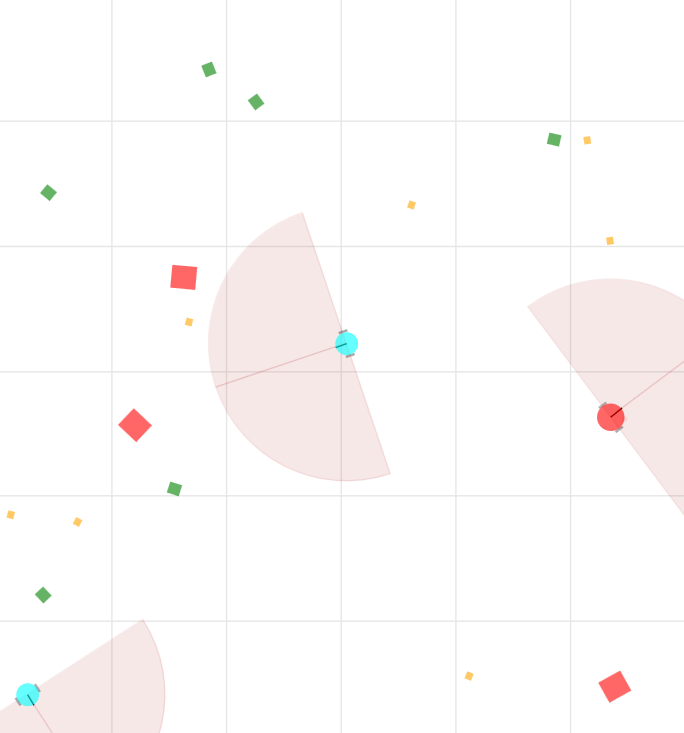

In [45]:
stop_server_and_interface()
controller.stop()

Received signal 15, shutting down
Server and Interface Stopped
